In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row

import matplotlib.colors as mcolors

cmap_data = [(1.0,                1.0,                 1.0),
             (0.3137255012989044, 0.8156862854957581,  0.8156862854957581),
             (0.0,                1.0,                 1.0),
             (0.0,                0.8784313797950745,  0.501960813999176),
             (0.0,                0.7529411911964417,  0.0),
             (0.501960813999176,  0.8784313797950745,  0.0),
             (1.0,                1.0,                 0.0),
             (1.0,                0.6274510025978088,  0.0),
             (1.0,                0.0,                 0.0),
             (1.0,                0.125490203499794,   0.501960813999176),
             (0.9411764740943909, 0.250980406999588,   1.0),
             (0.501960813999176,  0.125490203499794,   1.0),
             (0.250980406999588,  0.250980406999588,   1.0),
             (0.125490203499794,  0.125490203499794,   0.501960813999176),
             (0.125490203499794,  0.125490203499794,   0.125490203499794),
             (0.501960813999176,  0.501960813999176,   0.501960813999176),
             (0.8784313797950745, 0.8784313797950745,  0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872,  0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525,  0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours

wclevs  = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs  = list(-40.0 + 2*np.arange(41))

pclevs  = list(-15.0 + np.arange(31))

dclevs  = list(-20.0 + np.arange(41))

zlevels = 25.0 + 60.*np.arange(300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
loc_s3  = '/work/wicker/climate_runs/FV3_Solo/bubble_3km'
loc_c3  = '/work/wicker/climate_runs/cm1r20.3/run/bubble_3km'
loc_s2  = '/work/wicker/climate_runs/FV3_Solo/bubble_2km'
loc_c2  = '/work/wicker/climate_runs/cm1r20.3/run/bubble_2km'
loc_s1  = '/work/wicker/climate_runs/FV3_Solo/bubble_1km'
loc_c1  = '/work/wicker/climate_runs/cm1r20.3/run/bubble_1km'

In [26]:
s3 = read_solo_fields(loc_s3, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)
c3 = read_cm1_fields(loc_c3, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/FV3_Solo/bubble_3km/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/FV3_Solo/bubble_3km/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/climate_runs/FV3_Solo/bubble_3km/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/bubble_3km/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicke

(0.0, 3600.0)

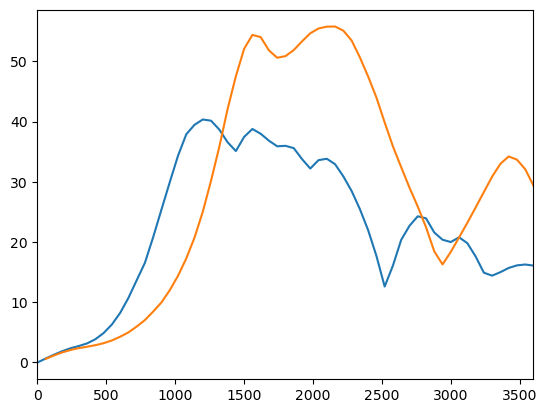

In [29]:
# TEST plot
plt.plot(c3.sec, c3.w.max(axis=(1,2,3)))
plt.plot(s3.sec, s3.w.max(axis=(1,2,3)))
plt.xlim(0,3600)

In [30]:
s2 = read_solo_fields(loc_s2, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)
c2 = read_cm1_fields(loc_c2, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/FV3_Solo/bubble_2km/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/FV3_Solo/bubble_2km/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/climate_runs/FV3_Solo/bubble_2km/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/bubble_2km/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicke

In [31]:
s1 = read_solo_fields(loc_s1, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)
c1 = read_cm1_fields(loc_c1, file_pattern=None, ret_obj=True, ret_dbz=False, ret_ds=False)

------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/FV3_Solo/bubble_1km/atmos_hifreq.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/FV3_Solo/bubble_1km/atmos_hifreq.nc 

 Completed reading in:  /work/wicker/climate_runs/FV3_Solo/bubble_1km/atmos_hifreq.nc 

------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/bubble_1km/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicke

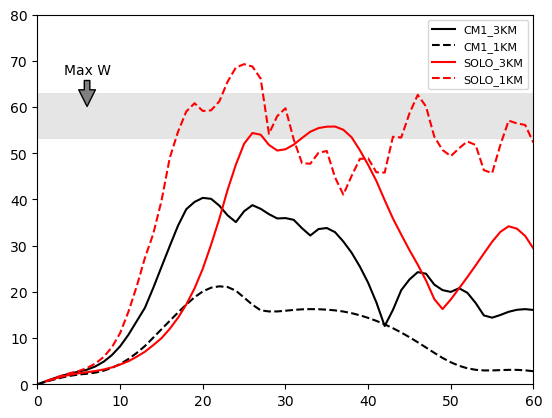

In [71]:
# Full plot

fig, ax = plt.subplots()

ax.plot(c3.min, c3.w.max(axis=(1,2,3)), color='k', linestyle='-',  label='CM1_3KM')
#plt.plot(c2.min, c2.w.max(axis=(1,2,3)), color='k', linestyle='.', label='CM1_2KM')
ax.plot(c1.min, c1.w.max(axis=(1,2,3)), color='k', linestyle='--', label='CM1_1KM')

ax.plot(s3.min, s3.w.max(axis=(1,2,3)), color='r', linestyle='-',  label='SOLO_3KM')
# plt.plot(s2.min, s2.w.max(axis=(1,2,3)), color='r', linestyle='.', label='SOLO_2KM')
ax.plot(s1.min, s1.w.max(axis=(1,2,3)), color='r', linestyle='--', label='SOLO_1KM')
ax.set_xlim(0,60)
ax.set_ylim(0,80)
ax.legend(fontsize=8)
ax.annotate('Max W',
            xytext=(6,68),
            xy=(6,60),
            xycoords='data',
            arrowprops=dict(facecolor='grey', shrink=0.02),
            horizontalalignment='center', verticalalignment='center')
ax.barh(58, 60, 10, color='k', alpha=0.1);

In [81]:

fields = []
fields.append(container(s3.w.max(axis=(2,3)).transpose(), s3.zc[0,:,0,0]/1000., s3.min))
fields.append(container(c3.w.max(axis=(2,3)).transpose(), s3.zc[0,:,0,0]/1000., c3.min))
#fields.append(container(cm1_w, zlevels, time2))

X/Y/2D:  (63, 60) (63,) (60,)
X:  (60,)
Y:  (63,)
FLD:  55.788128 0.0045907497
X:  60.0 1.0
Y:  46.39805 0.023659408
X/Y/2D:  (63, 61) (63,) (61,)
X:  (61,)
Y:  (63,)
FLD:  40.346687 0.0
X:  60.0 0.0
Y:  46.39805 0.023659408


PLOT_ROW_CONTOUR:   55.788128 0.0045907497
PLOT_ROW_CONTOUR:   60.0 1.0
PLOT_ROW_CONTOUR:   46.39805 0.023659408
PLOT_ROW_CONTOUR:   40.346687 0.0
PLOT_ROW_CONTOUR:   60.0 0.0
PLOT_ROW_CONTOUR:   46.39805 0.023659408


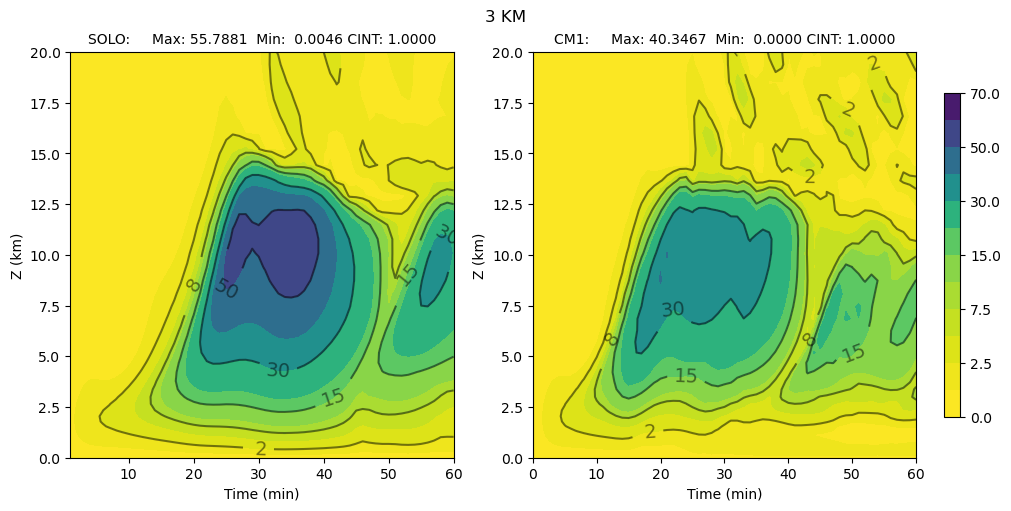

In [83]:
plot_contour_row(fields, levels=wclevs, suptitle='3 KM', ptitle=['SOLO','CM1'], xlabel='Time (min)', ylabel='Z (km)', extra_levels=wclevs, 
                 cmap=plt.cm.viridis_r, cint=2.5, ylim=(0,20.));

<xarray.DataArray 'theta' ()> Size: 4B
array(1593.5781, dtype=float32)
Coordinates:
    grid_xt  float32 4B 1.0
    grid_yt  float32 4B 1.0
    time     float32 4B 60.0


(63, 64) 2.9472046


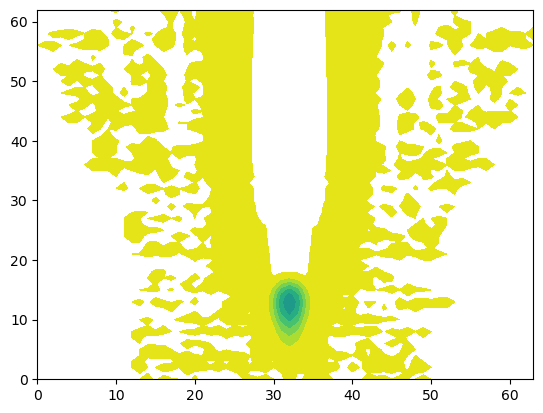

In [101]:
cmin = 0.0
cmax = 5.0
cinc = 1.0
cntlevels = 0.5*np.arange(13)

t0 = s3.theta[0,:,0,0]

s_t = s3.theta[0,:,jloc,:]

ppt = np.zeros_like(s_t)

for k in np.arange(s_t.shape[0]):
    ppt[k,:] = s_t[k,:] - t0[k]

print(ppt.shape,ppt.max())

ppt = ppt[::-1,]

plt.contourf(ppt[:,:], levels=cntlevels, cmap=plt.cm.viridis_r)

(63, 64) <xarray.DataArray 'thpert' ()> Size: 4B
array(2.6723874, dtype=float32)
Coordinates:
    time     float32 4B 0.0
    yh       float32 4B 121.5


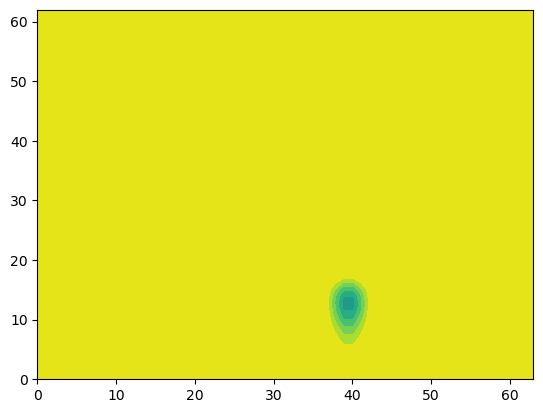

In [98]:
cmin = 0.0
cmax = 5.0
cinc = 1.0
cntlevels = 0.5*np.arange(13)

t0 = c3.th[0,:,0,0]

s_t = c3.th[1,:,jloc,:]

ppt = c3.thpert[0,:,40,:]

# for k in np.arange(s_t.shape[0]):
#     ppt[k,:] = s_t[k,:] - t0[k]

print(ppt.shape,ppt.max())

plt.contourf(ppt[:,:], levels=cntlevels, cmap=plt.cm.viridis_r)